# Preprocess the Model for Ratio Reconstruction

### TO DO:
Have some simple tests that check data when loading. Leverage existing reading tools but add project specific checks later
* station data
* [x] ensemble mean
* [x] mask?
* Have option to use PyKrige or R for reconstruction?

In [1]:
from climpyrical.data import read_data, gen_dataset, interpolate_dataset
from climpyrical.gridding import regrid_ensemble, extend_north
from climpyrical.mask import stratify_coords
from pkg_resources import resource_filename

import xarray as xr
import numpy as np
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib

import os

font = {'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = (10, 10)

%load_ext autoreload
%autoreload 2

## Interpolate the model

In [17]:
# Establish paths dictionary

# station_dv = 'RL50 (kPa)'
# station_dv = 'mean RH (%)'
# station_dv = 'HDD (deg C)'
# station_dv = 'SL50 (kPa)'
# station_dv = 'Q10_Gumbel-MM'
station_dv = 'Q50_Gumbel-MM'
# station_dv = 'TJan2.5 (degC)'
# station_dv = 'TJan1.0 (degC)'


paths = {
    'RL50 (kPa)': 'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc',
    'mean RH (%)': 'nrc_data/hurs_CanRCM4-LE_ens15_1951-2016_ensmean.nc',
    'HDD (deg C)': 'nrc_data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc',
    'SL50 (kPa)': 'nrc_data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc',
    'Q10_Gumbel-MM': 'nrc_data/wpress_CanRCM4-LE_ens35_1951-2016_max_rl10_kpa_ensmean.nc',
    'Q50_Gumbel-MM': 'nrc_data/wpress_CanRCM4-LE_ens35_1951-2016_max_rl50_kpa_ensmean.nc',
    'TJan2.5 (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan2.5p_ensmean.nc',
    'TJan1.0 (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan1.0p_ensmean.nc'
}

PATH_MEAN_SNOW = resource_filename(
    'climpyrical', 
    'nrc_data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

PATH_MEAN = resource_filename(
    'climpyrical',
    paths[station_dv]
)

file_dv = station_dv.split(' ')[0]
ds_mean = read_data(PATH_MEAN)
dv = list(ds_mean.data_vars)[0]

In [18]:
# Create coordinate grids
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)

Load the Surface to Land Fraction Mask `sftlf`

In [19]:
PATH_MASK = resource_filename('climpyrical', 'nrc_data/land_mask_CanRCM4_sftlf.nc')
PATH_GLACIER_MASK = resource_filename('climpyrical', 'nrc_data/glacier_mask.nc')

# load mask data
mask = read_data(PATH_MASK)

# regrid dataset to target resolution
mask = regrid_ensemble(mask, 'sftlf', 10, copy=True)

# convert to boolean mask
mask = mask['sftlf'] >= 1.0

Use regridded mask to reference the new coordinates on the map

In [20]:
# Create array of mean
if 'degC' in station_dv and not 'degC-day' in station_dv:
    mean = ds_mean[dv].values + 273.15
else:
    mean = ds_mean[dv].values

mask_og = read_data(PATH_MASK)['sftlf'].values

glaciermask = read_data(PATH_GLACIER_MASK)['mask'].values

fill_glaciers = True
if fill_glaciers:
    mean[glaciermask] = np.nan
nanmask = ~np.isnan(mean)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_values = mean[nanmask]
target_points = np.stack([rlon[glaciermask], rlat[glaciermask]]).T

mean[glaciermask] = interpolate_dataset(points, target_values, target_points, 'linear')

ds_mean_glacier_filled = gen_dataset(dv, mean, ds_mean.rlon, ds_mean.rlat)

In [21]:
# send to DVE
regrid_ensemble(ds_mean_glacier_filled, dv, 10, copy=True, keys=['rlat', 'rlon']).to_netcdf(f'~/dash-dv-explorer/assets/data/ensemble/{file_dv}_10_ensemble_mean.nc')

In [22]:
path_shapefile = resource_filename('climpyrical', 'nrc_data/canada_final.shp')
canada = gpd.read_file(path_shapefile).geometry
X, Y = stratify_coords(canada)

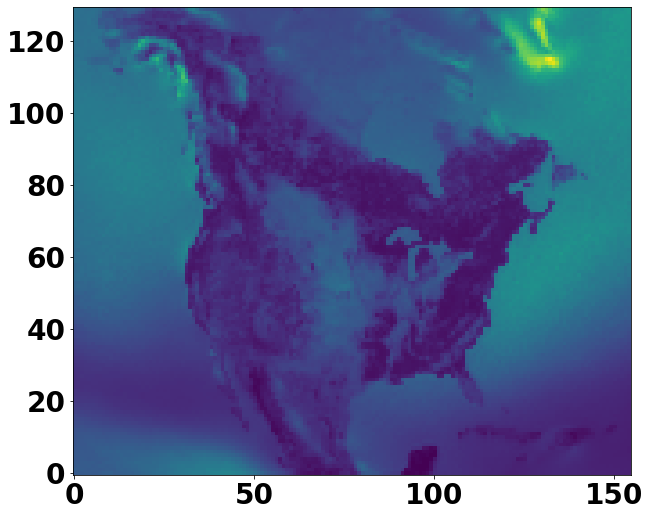

In [23]:
plt.imshow(ds_mean_glacier_filled[dv], origin='lower')

In [24]:
ds10_cp = regrid_ensemble(ds_mean_glacier_filled, dv, 10, copy=True, keys=['rlat', 'rlon'])
ds10_cp_ext = extend_north(ds10_cp, dv, 210, fill_val=np.nan)
nanmask10 = ~np.isnan(ds10_cp_ext[dv].values)

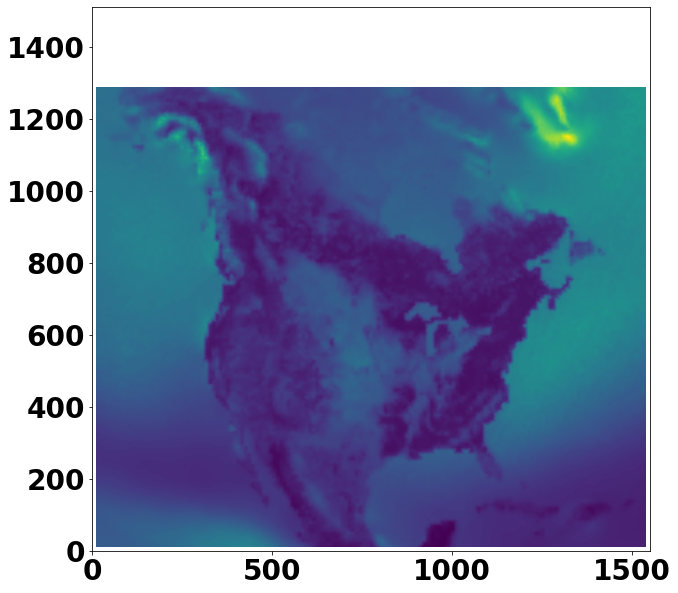

In [25]:
# find NaN values in ensemble mean
mean_glacier_filled = ds_mean_glacier_filled[dv].values
nanmask = ~np.isnan(mean_glacier_filled)

# create interpolator for non NaN values
# new coordinates to interpolate to (ds10_cp_ext is at target resolution)
nrlon, nrlat = np.meshgrid(ds10_cp_ext.rlon.values, ds10_cp_ext.rlat.values)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T

mean10 = ds10_cp_ext[dv].values
mean10[nanmask10] = interpolate_dataset(points, mean_glacier_filled[nanmask], target_points, 'linear')

ds_mean10_nx = gen_dataset(dv, mean10, ds10_cp_ext.rlon.values, ds10_cp_ext.rlat.values)

plt.imshow(ds_mean10_nx[dv], origin='lower')

Extend to the north for non-modelled region

Load final refined mask. If not accessible, or desire difference shapefile, follow `mask.ipynb`

(1510, 1550)


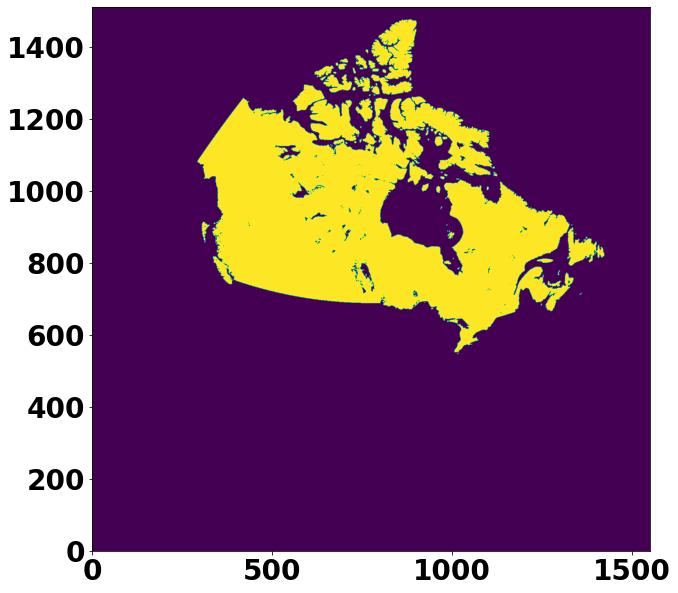

In [26]:
mask_path = resource_filename('climpyrical', '/nrc_data/processed/canada_mask_rp.nc')

with read_data(mask_path) as ds:
    print(ds['mask'].shape)
    rmask = ds['mask'].values

plt.imshow(rmask, origin='lower')

Find inconsistent areas between the refined mask and the model by comparing model values with refined mask values

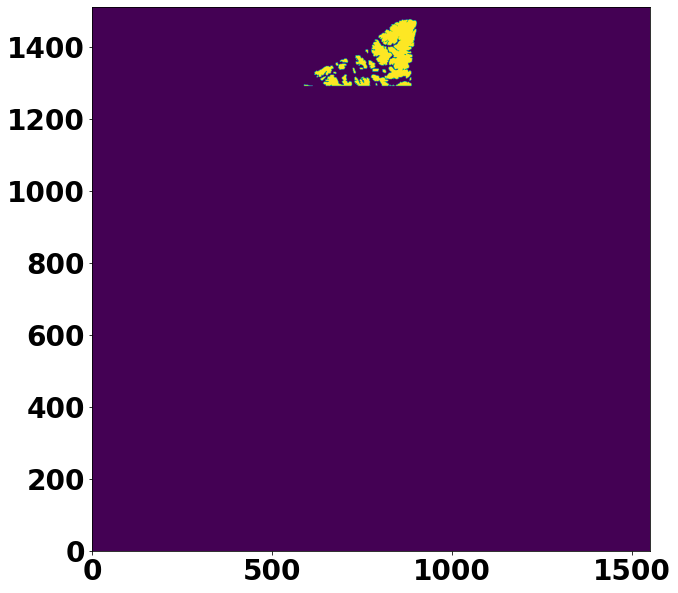

In [27]:
nanmask10 = ~np.isnan(ds_mean10_nx[dv])
rmask_or = ~np.logical_or(~rmask, nanmask10)

plt.imshow(rmask_or, origin='lower')

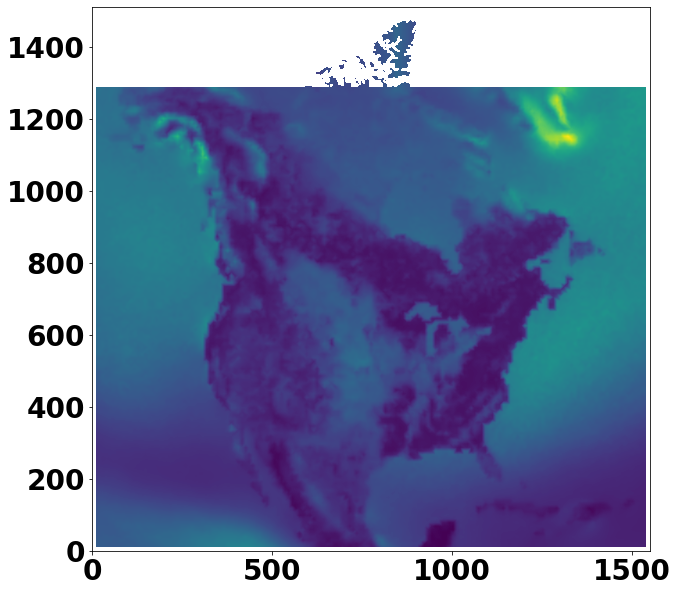

In [28]:
# Fill inconsistent points using closest neighbour.
# Not that the northern section will be filled later on

temp_field = ds_mean10_nx[dv].values

points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
f = NearestNDInterpolator(points, ds_mean10_nx[dv].values[nanmask10])
temp_field[rmask_or] = f(np.stack([nrlon[rmask_or], nrlat[rmask_or]]).T)

mean10_ext_f = xr.Dataset(
    {dv: (["rlat", "rlon"], temp_field)},
    coords={"rlon": ("rlon", ds_mean10_nx.rlon), "rlat": ("rlat", ds_mean10_nx.rlat)},
)

plt.imshow(mean10_ext_f[dv], origin='lower')

In [29]:
# Check all inconsistencies are filled
assert ~np.any(~np.logical_or(~rmask, ~np.isnan(mean10_ext_f[dv]))).values

In [30]:
pre_processed_path = resource_filename(
    "climpyrical", 
    f"/nrc_data/processed/{file_dv}_pre_processed.nc"
)

if os.path.exists(pre_processed_path):
    os.remove(pre_processed_path)
    mean10_ext_f.to_netcdf(pre_processed_path, 'w')
else:
    mean10_ext_f.to_netcdf(pre_processed_path, 'w')

In [31]:
mean10_ext_f

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    rl50     (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan